In [11]:
import ringdown
from ringdb import Database
import lalsimulation as ls
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

db = Database('./Data')
db.initialize()

#### Choose Event

In [12]:
eventname = 'GW150914'
event = db.event(eventname)
strains = event.strain()
posts = event.posteriors()

db.update_posterior_schema({'f_low': {'path': "/{approximant}/meta_data/meta_data/f_low", 'type':'value'}})
db.update_posterior_schema({'f_ref': {'path': "/{approximant}/meta_data/meta_data/f_ref", 'type':'value'}})

print(event.PD_ref.choose_approximant(event.name))

C01:IMRPhenomXPHM


#### Compute t_peak using some approximant

In [33]:
new_approximant = None
#new_approximant = 'C01:SEOBNRv4PHM'

fd_or_td = 'td'

try:
    if new_approximant:
        posts = pd.DataFrame(event.read_posterior_file_from_schema('samples',approximant=new_approximant))
        f_low = float(event.read_posterior_file_from_schema('f_low', approximant=new_approximant))
        f_ref = float(event.read_posterior_file_from_schema('f_ref', approximant=new_approximant))
        waveform_name = new_approximant.replace('C01:','')
        waveform_code = getattr(ls, waveform_name)
    else:
        # Use the standard approximant
        f_low = float(event.read_posterior_file_from_schema('f_low'))
        f_ref = float(event.read_posterior_file_from_schema('f_ref'))
        waveform_name = posts['waveform_name'].unique()[0]
        waveform_code = int(posts['waveform_code'].unique()[0])
except:
    print("Falling back to f_ref = 20, f_low=20")
    waveform_name = posts['waveform_name'].unique()[0]
    waveform_code = int(posts['waveform_code'].unique()[0])
    f_low = 20
    f_ref = 20

print(f"Using {waveform_name}")
wf_ls = waveform_code
sample_rate = np.max([a.fsamp for a in strains.values()])
target_sample_rate = 4096

samps = [x.to_dict() for i,x in posts.sample(min(800, len(posts))).iterrows()]

for i,x in enumerate(samps):
    if fd_or_td == 'fd':
        t_peak, t_dict, hp, hc = ringdown.complex_strain_peak_time_fd(x,
                                                                      wf=wf_ls,
                                                                      f_ref=f_ref, f_low=f_low, df=0.1,
                                                                      f_high=target_sample_rate)
        samps[i].update({k+'_peak':v.ns()*1e-9 for k,v in t_dict.items()})
    else:
        t_peak, t_dict, hp, hc = ringdown.complex_strain_peak_time_td(x,
                                                                      wf=wf_ls, dt=1/target_sample_rate,
                                                                      f_ref=f_ref, f_low=f_low)
        samps[i].update({k+'_peak':v for k,v in t_dict.items()})
    
samps = pd.DataFrame(samps)

Using IMRPhenomXPHM


#### Choose median sample based on some reference ifo (or geocent):

In [34]:
# Get median sample
ref_ifo = 'H1'
im = (samps[f'{ref_ifo}_peak'] - samps[f'{ref_ifo}_peak'].quantile(0.5)).abs().argmin()
median_samp = samps.iloc[im]

# Construct Arguments for set_target
args = median_samp[['geocent_peak', 'ra','dec','psi']].rename({'geocent_peak':'t0'}).to_dict()
print("The median time at H1 is: ", median_samp['H1_peak'], "s")

# Get the mass time-scale
Mass_Time = lambda M: 6.674e-11*M*1.989e+30/(3e8)**3
t_M = Mass_Time(median_samp['final_mass'])
print("The mass time-scale is: ", np.round(t_M*1000,3), "ms")

times_above_below = (samps['H1_peak'].quantile(0.95) - samps['H1_peak'].quantile(0.05))/(2*t_M)
print(f"The 90% CI of H1 peak time is +/- {np.round(times_above_below,1)} t_M")

The median time at H1 is:  1126259462.4240782 s
The mass time-scale is:  0.34 ms
The 90% CI of H1 peak time is +/- 5.1 t_M


In [37]:
samps.H1_peak.median()

1126259462.424079

In [38]:
fit = ringdown.Fit(model='mchi', modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])

fit.add_data(strains['H1'])
fit.add_data(strains['L1'])

fit.set_target(**args, duration=0.1)
fit.condition_data(ds=int(sample_rate/target_sample_rate),digital_filter=True)
fit.compute_acfs()

fit.update_prior(A_scale=5e-21, M_min=median_samp['final_mass']*0.5,
                 M_max=median_samp['final_mass']*2.0,
                 flat_A=1)

In [39]:
fit.run(draws=2000, target_accept=0.95, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, Apx_unit, Apy_unit, Acx_unit, Acy_unit, df, dtau]
INFO:pymc:NUTS: [M, chi, Apx_unit, Apy_unit, Acx_unit, Acy_unit, df, dtau]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 188 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 188 seconds.


In [40]:
def combined_results(fit_result, imrs):
    cols = [(r'$M$','M'), (r'$\chi$','chi')]
    the_result = pd.DataFrame({col[0]: fit_result['posterior'][col[1]].values.flatten() for col in cols})
    the_result['result'] = 'Ringdown'

    cols = [(r'$M$','final_mass'), (r'$\chi$','final_spin')]
    the_result2 = pd.DataFrame({col[0]: posts[col[1]].values.flatten() for col in cols})
    the_result2['result'] = 'IMR'

    the_result = pd.concat([the_result, the_result2]).reset_index(drop=True)
    return the_result

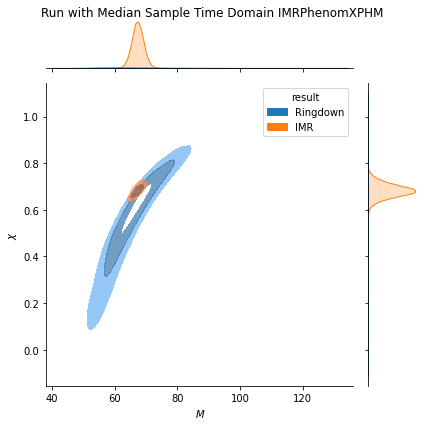

In [41]:
the_result = combined_results(fit.result, posts)
g = sns.jointplot(data=the_result, x=r'$M$', y=r'$\chi$', hue='result', 
              kind='kde', fill=True, levels=[0.3,0.6,0.9], common_norm=False, alpha=0.7)

g.fig.suptitle("Run with Median Sample Time Domain IMRPhenomXPHM")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

fit.result.to_netcdf(f'{eventname}-Median-td-{waveform_name}.nc')
plt.show()

In [ ]:
the_result = combined_results(fit.result, posts)
g = sns.jointplot(data=the_result, x=r'$M$', y=r'$\chi$', hue='result', 
              kind='kde', fill=True, levels=[0.3,0.6,0.9], common_norm=False, alpha=0.7)

g.fig.suptitle("Run with Median Sample Time Domain IMRPhenomXPHM")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

fit.result.to_netcdf(f'{eventname}-Median-td-{waveform_name}.nc')
plt.show()

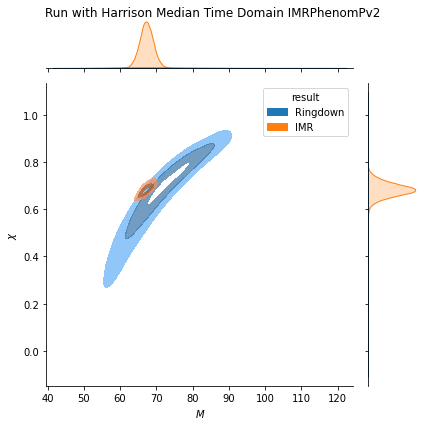

In [110]:
the_result = combined_results(fit.result, posts)
g = sns.jointplot(data=the_result, x=r'$M$', y=r'$\chi$', hue='result', 
              kind='kde', fill=True, levels=[0.3,0.6,0.9], common_norm=False, alpha=0.7)

g.fig.suptitle("Run with Harrison Median Time Domain IMRPhenomPv2")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)
fit.result.to_netcdf(f'{eventname}-Harrison-td-{waveform_name}.nc')
plt.show()

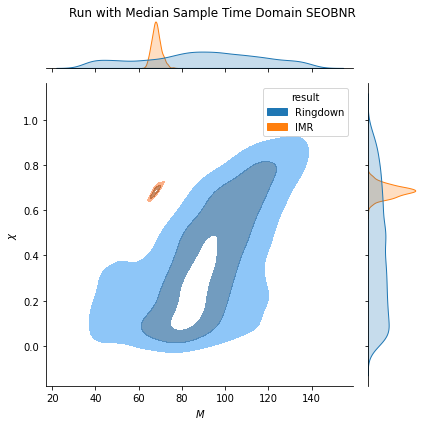

In [9]:
the_result = combined_results(fit.result, posts)
g = sns.jointplot(data=the_result, x=r'$M$', y=r'$\chi$', hue='result', 
              kind='kde', fill=True, levels=[0.3,0.6,0.9], common_norm=False, alpha=0.7)

g.fig.suptitle("Run with Median Sample Time Domain SEOBNR")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

fit.result.to_netcdf(f'{eventname}-Median-td-{waveform_name}.nc')
plt.show()

In [44]:
def get_quantile_samp(samps, col, q=0.5):
    im = (samps[col] - samps[col].quantile(0.5)).abs().argmin()
    median_samp = samps.iloc[im]
    return median_samp

In [49]:
get_quantile_samp(samps, 'luminosity_distance')

chirp_mass               31.147792
mass_ratio                0.947932
a_1                       0.476788
a_2                       0.729939
tilt_1                    0.980501
                       ...        
waveform_code                  101
geocent_peak     1126259462.410554
H1_peak          1126259462.422014
L1_peak          1126259462.415101
V1_peak          1126259462.423272
Name: 266, Length: 143, dtype: object

In [55]:
import ringdown

In [57]:
ringdown.model.chiq_exact_factors

<function ringdown.model.chiq_exact_factors(chi, Q, bij, cij, Y0)>